In [1]:
from prefect import task, Flow
from prefect.engine.results import LocalResult
import rad_pipeline.zipcodes as zc
import rad_pipeline.rad_pipeline as rp
import great_expectations as ge
import datacompy
import os

In [2]:
import importlib
importlib.reload(rp)
importlib.reload(zc)

<module 'rad_pipeline.zipcodes' from '/Users/alexhasha/repos/massenergize/rad_pipeline/rad_pipeline/zipcodes.py'>

In [3]:
os.getcwd()

'/Users/alexhasha/repos/massenergize/rad_pipeline/notebooks'

In [4]:
#TODO: Figure out how to get intermediate results cached for quick pipeline rerun on failure

load_ashp = task(rp.load_ashp, result=LocalResult(), target="{flow_run_id}/{scheduled_start_time:%Y-%d-%m}/load_ashp.pkl")
data_clean = task(rp.data_clean, result=LocalResult(), target="{flow_run_id}/{scheduled_start_time:%Y-%d-%m}/clean_ashp.pkl")
data_checkpoint = task(rp.data_checkpoint, result=LocalResult(), target="{flow_run_id}/{scheduled_start_time:%Y-%d-%m}/checkpoint_ashp.pkl")
dq_check = task(rp.dq_check)
clean_data_load = task(rp.clean_data_load)

In [5]:
@task
def verify_equal(df, from_disk):
    compare = datacompy.Compare(
        df,
        from_disk,
        on_index=True,
        abs_tol=1e-5, #Optional, defaults to 0
        rel_tol=1e-5, #Optional, defaults to 0
        df1_name='In Memory', #Optional, defaults to 'df1'
        df2_name='From Disk' #Optional, defaults to 'df2'
    )
    if not compare.matches(ignore_extra_columns=False):
        print(compare.report())
        raise ValueError("Reload from disk mismatch")
    
    return compare

In [6]:
with Flow("RAD pipeline: ASHP") as flow:
    source = "Air-source Heat Pumps"
    ashp = load_ashp()
    dq_check(ashp, source, "raw")
    ashp_cleaned = data_clean(ashp, source)
    ashp_checkpointed = data_checkpoint(
        ashp_cleaned,
        "Air-source Heat Pumps"
    )
    
    ashp_from_disk = clean_data_load(source)
    dq_check(ashp_from_disk, source, "clean")
    ashp_from_disk.set_upstream(ashp_checkpointed, flow=flow)
    verify_equal(ashp_checkpointed, ashp_from_disk)

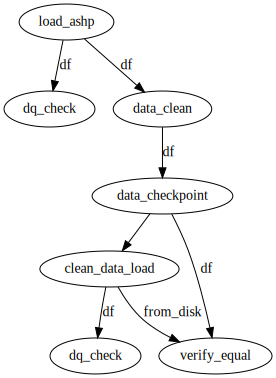

In [7]:
flow.visualize()

In [8]:
flow_state = flow.run()

[2021-03-21 09:42:00-0400] INFO - prefect.FlowRunner | Beginning Flow run for 'RAD pipeline: ASHP'
[2021-03-21 09:42:00-0400] INFO - prefect.TaskRunner | Task 'load_ashp': Starting task run...
[2021-03-21 09:42:04-0400] INFO - prefect.TaskRunner | Task 'load_ashp': Finished task run for task with final state: 'Success'
[2021-03-21 09:42:04-0400] INFO - prefect.TaskRunner | Task 'data_clean': Starting task run...
[2021-03-21 09:43:53-0400] INFO - prefect.TaskRunner | Task 'data_clean': Finished task run for task with final state: 'Success'
[2021-03-21 09:43:53-0400] INFO - prefect.TaskRunner | Task 'dq_check': Starting task run...
{
  "statistics": {
    "evaluated_expectations": 14,
    "successful_expectations": 14,
    "unsuccessful_expectations": 0,
    "success_percent": 100.0
  },
  "meta": {
    "great_expectations_version": "0.13.14",
    "expectation_suite_name": "default",
    "run_id": {
      "run_name": null,
      "run_time": "2021-03-21T13:43:53.304943+00:00"
    },
    "

[2021-03-21 09:43:53-0400] INFO - prefect.TaskRunner | Task 'data_checkpoint': Starting task run...
[2021-03-21 09:43:54-0400] INFO - prefect.TaskRunner | Task 'data_checkpoint': Finished task run for task with final state: 'Success'
[2021-03-21 09:43:54-0400] INFO - prefect.TaskRunner | Task 'clean_data_load': Starting task run...
[2021-03-21 09:43:54-0400] INFO - prefect.TaskRunner | Task 'clean_data_load': Finished task run for task with final state: 'Success'
[2021-03-21 09:43:54-0400] INFO - prefect.TaskRunner | Task 'dq_check': Starting task run...
{
  "statistics": {
    "evaluated_expectations": 7,
    "successful_expectations": 7,
    "unsuccessful_expectations": 0,
    "success_percent": 100.0
  },
  "meta": {
    "great_expectations_version": "0.13.14",
    "expectation_suite_name": "default",
    "run_id": {
      "run_name": null,
      "run_time": "2021-03-21T13:43:54.796137+00:00"
    },
    "batch_kwargs": {
      "ge_batch_id": "7a89b89e-8a4b-11eb-b322-003ee1b9b7c7"
  

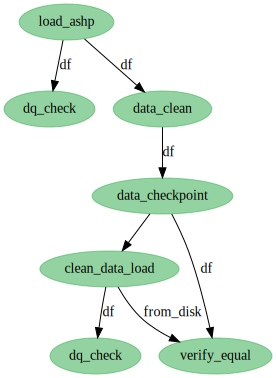

In [9]:
flow.visualize(flow_state=flow_state)

### Inspecting task results

In [15]:
tasks = flow.get_tasks()
tasks

[<Task: dq_check>,
 <Task: data_checkpoint>,
 <Task: load_ashp>,
 <Task: clean_data_load>,
 <Task: data_clean>,
 <Task: dq_check>,
 <Task: verify_equal>]

In [16]:
ashp_cleaned_df = flow_state.result[tasks[3]]._result.value

In [17]:
ashp_cleaned_df.shape

(18856, 26)

# GHSP

In [ ]:
load_gshp = task(rp.load_gshp)

In [ ]:
with Flow("RAD pipeline: GSHP") as flow:
    gshp = load_gshp()
    gshp_cleaned = data_clean(gshp, "Ground-source Heat Pumps")
    gshp_cleaned = data_checkpoint(
        gshp_cleaned,
        "Ground-source Heat Pumps"
        )


In [ ]:
flow_state = flow.run()

In [ ]:
flow.visualize(flow_state=flow_state)